# Eval and visualisation (UCF101) 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import torchvision.transforms as transforms
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from torch.utils.data import DataLoader

from lumen.models.clip import load as load_clip
from lumen.models.clip import tokenize as clip_tokenize
from lumen.models import LuMenAttention
from lumen.dataset_uq.utils import ConvertImageToRGB  
from lumen.dataset_uq import UCF101Dataset
import lumen.lib as lib





## Loading backbone dataset and uncertainties model

In [2]:
lvu_path = '../weights/lvu_ucf.ckpt'
lumen_path = '../weights/lumen_ucf.ckpt'
visu_path = '../visu/ucf'
os.makedirs(visu_path,exist_ok=True)
dataset = 'UCF101'


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clip_model, _ = load_clip("ViT-B/32")
clip_model.to(device)
print('CLIP model loaded')

CLIP model loaded


In [4]:
val_transforms = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC), 
    transforms.CenterCrop(224),
    ConvertImageToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])
dts_val = UCF101Dataset('../data/UCF-101-midframes',split='test',transform=val_transforms)
dataloader_val = DataLoader(dts_val, batch_size=128, shuffle=False, num_workers=4)

In [5]:

lvu = LuMenAttention(
                                        concat=True,
                                        identity_init=True,
                                        n_iter_freeze_proj=1000,
                                        use_predicted_caption=False,
                                        use_attention=False,
                                        )

lumen = LuMenAttention(
                                        concat=True,
                                        identity_init=True,
                                        n_iter_freeze_proj=1000,
                                        use_predicted_caption=True,
                                        use_attention=True,
                                        )


template = "A photo of a {}."
logit_scale = lumen.logit_scale

In [6]:
lvu.load_state_dict(torch.load(lvu_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')['state_dict'])
lumen.load_state_dict(torch.load(lumen_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')['state_dict'])
lvu.to(device)
lumen.to(device)
lvu.eval()
lumen.eval()
print('Models loaded')

Models loaded


## Evaluate pretrain LuMen model

In [7]:
lvu_success = []
lvu_failure = []
lumen_success = []
lumen_failure = []
missclassifieds = []
tcps_success = []
tcps_failure = []
mcps_success = []
mcps_failure = []
total_iter = 0
with torch.no_grad():
    class_names = dataloader_val.dataset.class_names
    class_names = clip_tokenize([template.format(name) for name in class_names])
    for i, batch in enumerate(dataloader_val):
        images = batch["image"]
        labels = batch["target"].to(device)
        visual_feats = clip_model.encode_image(images.to(device))
        visual_feats /= visual_feats.norm(dim=-1, keepdim=True)
        
        text_feats = clip_model.encode_text(class_names.to(device))
        text_feats /= text_feats.norm(dim=-1, keepdim=True)

        probs = torch.softmax(logit_scale * visual_feats @ text_feats.t(), dim=-1)
        with torch.autocast(device_type='cuda'):
            lvu_scores = lvu(visual_feats, text_feats).squeeze(-1)
            lumen_scores = lumen(visual_feats, text_feats).squeeze(-1)

        missclassified = labels != probs.argmax(dim=-1)

        tcps = probs[torch.arange(labels.size(0)), labels]
        mcps = probs.max(dim=-1).values

        lvu_success.append(lvu_scores[~missclassified])
        lvu_failure.append(lvu_scores[missclassified])
        lumen_success.append(lumen_scores[~missclassified])
        lumen_failure.append(lumen_scores[missclassified])
        missclassifieds.append(missclassified)
        mcps_success.append(mcps[~missclassified])
        mcps_failure.append(mcps[missclassified])
    
    missclassifieds = torch.cat(missclassifieds).cpu().numpy()
    lvu_success_sigmoid = torch.sigmoid(torch.cat(lvu_success)).cpu().numpy()
    lvu_failure_sigmoid = torch.sigmoid(torch.cat(lvu_failure)).cpu().numpy()
    lumen_success_sigmoid = torch.sigmoid(torch.cat(lumen_success)).cpu().numpy()
    lumen_failure_sigmoid = torch.sigmoid(torch.cat(lumen_failure)).cpu().numpy()
    lvu_success = torch.cat(lvu_success).cpu().numpy()
    lvu_failure = torch.cat(lvu_failure).cpu().numpy()
    lumen_success = torch.cat(lumen_success).cpu().numpy()
    lumen_failure = torch.cat(lumen_failure).cpu().numpy()
    mcps_success = torch.cat(mcps_success).float().cpu().numpy()
    mcps_failure = torch.cat(mcps_failure).float().cpu().numpy()

    fpr_lvu = lib.get_fpr(lvu_success, lvu_failure)
    auc_lvu = lib.get_auroc(lvu_success, lvu_failure)

    fpr_lumen = lib.get_fpr(lumen_success, lumen_failure)
    auc_lumen = lib.get_auroc(lumen_success, lumen_failure)

    fpr_mcm = lib.get_fpr(mcps_success, mcps_failure)
    auc_mcm = lib.get_auroc(mcps_success, mcps_failure)


In [8]:
print(f"AUC MCM: {auc_mcm:.4f}")
print(f"FPR MCM: {fpr_mcm:.4f}")
print(f"AUC LVU: {auc_lvu:.4f}")
print(f"FPR LVU: {fpr_lvu:.4f}")
print(f"AUC LuMen: {auc_lumen:.4f}")
print(f"FPR LuMen: {fpr_lumen:.4f}")

AUC MCM: 0.8476
FPR MCM: 0.6569
AUC LVU: 0.8854
FPR LVU: 0.5419
AUC LuMen: 0.9566
FPR LuMen: 0.2088


## Uncertainty score distribution

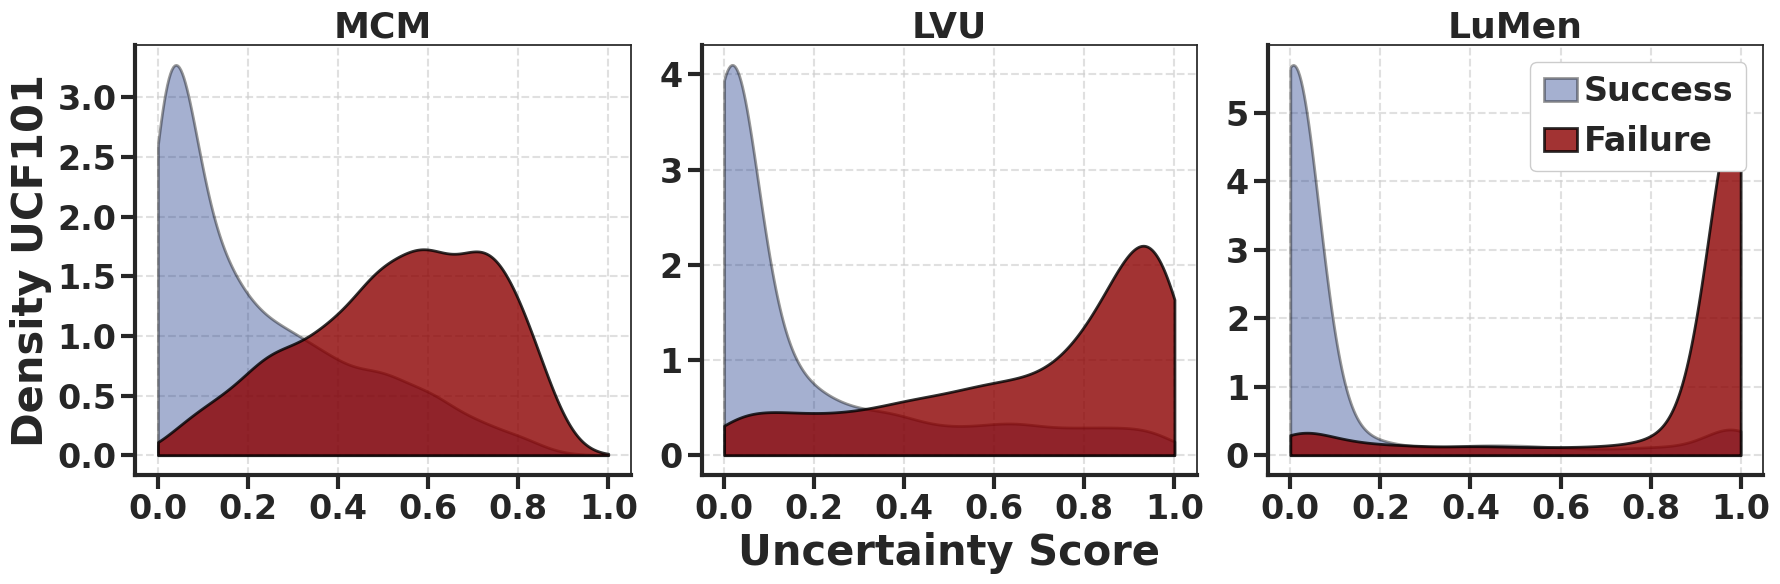

In [9]:

def plot_gaussian_distributions(mcps_success, mcps_failure, 
                                lvu_success, lvu_failure, 
                                lumen_success, lumen_failure):


    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 24  
    plt.rcParams['xtick.labelsize'] = 26  
    plt.rcParams['ytick.labelsize'] = 26  
    sns.set_theme(style="ticks")


    success_color = "#1E3A8A"  
    failure_color = "#8B0000"  

    methods = [
        (mcps_success, mcps_failure, "MCM"),
        (lvu_success, lvu_failure, "LVU"),
        (lumen_success, lumen_failure, "LuMen")
    ]
    
    plt.figure(figsize=(18, 6))

    for i, (success, failure, method) in enumerate(methods):
        plt.subplot(1, 3, i + 1)


        success_kde = gaussian_kde(success)
        failure_kde = gaussian_kde(failure)

        x_vals = np.linspace(0, 1, 300)

        success_density = success_kde(x_vals)
        failure_density = failure_kde(x_vals)

        plt.fill_between(x_vals, success_density, color=success_color, alpha=0.4, 
                         edgecolor='black', linewidth=2, label="Success")
        plt.fill_between(x_vals, failure_density, color=failure_color, alpha=0.8, 
                         edgecolor='black', linewidth=2, label="Failure")

        plt.title(f"{method}", fontsize=26, fontweight='bold')

        if i == 1:
            plt.xlabel("Uncertainty Score", fontsize=30, fontweight='bold')
        if i == 0:  
            plt.ylabel("Density "+dataset, fontsize=30, fontweight='bold')

        ax = plt.gca()
        ax.spines['bottom'].set_linewidth(3)  
        ax.spines['left'].set_linewidth(3)    
        ax.tick_params(axis='x', which='major', width=3, length=10) 
        ax.tick_params(axis='y', which='major', width=3, length=10)  
        
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontweight('bold')
            tick.set_fontsize(24)

        plt.grid(True, linestyle="--", linewidth=1.5, alpha=0.6)

    plt.legend(fontsize=24, loc='upper right', framealpha=1, handletextpad=0.2, 
               columnspacing=0.4, handlelength=1)

    plt.tight_layout()
    save_path = f"{visu_path}/failure_{dataset}.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_gaussian_distributions(1 - mcps_success, 1 - mcps_failure, 1 - lvu_success_sigmoid, 1 - lvu_failure_sigmoid, 1 - lumen_success_sigmoid, 1 - lumen_failure_sigmoid)
